# Bloom Value - Hospital Revnue(Net Amount) forecating

# Steps
1. Data Understanding, conacetnation, Exploratary Data Analysis
    > Observations:
        1. 82 days of hospital billing data
        2. Last Pay Mode - TPA has the highest net amount
        3. Sunday is the lean day. Saturay, Friday and Monday has higher net amount
        4. In-Paitent bill has the highest billing followed by Pharmacy
        5. Cash Pay mode is heavily used for Procedure Bill Type
        6. TPA is highest of In Paitent bill type and concentrated on Friday, Saturday and Monday
2. Null Value Imputation
    > Observations:
        1. USER col has 3 null values - imputed them with "Unknown"
        2. Discount column has null values - Imputed them with Bill Amount - Net Amount ( Mostly Zeroes)
        3. Last Pay Mode has 2112 Null vlaues
            . Case 1 - 6 rows , Bill Amount = Discount , hence no payment was done. Imputed with 'FREE"
            . Case 2 - 209 has Bill Amount = 0 and Net Amount = 0, hence looks dummy bills, imputed them with 'Dummy"
            . Case 3 - 1897 bill has Net Amount but the Paid Amount = 0 hence they are yet to pay, imputed them with "Due"
        4. Category column has 90% Null values, can impute with "Not Defined", as its not going to impact my analysis I left it untouched
        

3. Anonymization
4. Data preparation for forecasting
    > Two Approaches
        1. Daily Transaction Count Forecasting
        2. Daily Net Amount Forecasting
                Roll up the data date wise and for each Last pay Mode, Sanity checks( no missing dates), Time series decomposition,Stationartiy checks, Check the Autocorrelation ( ACF and PACF plots)
    
5. Apply Timeseries forecasting techniques
    > Time Series Forecasting Models
        1. Simple Average 
        2. Smiple Moving Average 
        3. Exponential Smoothing
        4. Double Exponential Smoothing
        5. Triple Exponential Smoothing
        6. ARIMA
        7. SARIMA
6. Evaluate the perfomance of models and picked the Triple Exponential Smoothing.

7. Model Deployment


In [2]:
#importing libraries

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Section 1 - Reading and Understanding the data
1. Open IPBills_Az.zip
2. Integrate the data from the 3 datasets programmatically.
3. Perfrom the descriptive statistics

In [3]:
#read all the files
os.chdir(r"C:\BloomValue")
bvoct = pd.read_excel("ip bills.xls oct_a.xlsx")
bvnov = pd.read_excel("ip bills.xls nov_a.xlsx")
bvdec = pd.read_excel("ip bills.xls Dec_a.xlsx")

In [4]:
bvoct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   #SlNo           7630 non-null   int64         
 1   Bill Type       7630 non-null   object        
 2   IPOP            7630 non-null   object        
 3   Bill No         7630 non-null   int64         
 4   Bill Date       7630 non-null   datetime64[ns]
 5   Bill Amount     7630 non-null   int64         
 6   Discount        7630 non-null   int64         
 7   Net Amount      7630 non-null   int64         
 8   Paid Amount     7630 non-null   int64         
 9   Balance Amount  7630 non-null   int64         
 10  Last Pay Mode   7123 non-null   object        
 11  User            7630 non-null   object        
 12  MRN             7630 non-null   int64         
 13  AdmID           7630 non-null   int64         
 14  Category        464 non-null    object        
dtypes: d

In [5]:
bvoct.sample(5)

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category
5114,5115,Procedure,OP,14200,2019-10-30 15:12:49,1400,0,1400,1400,0,CARD,anitha p-rad,435774,0,NaN
1682,1683,Pharmacy,IP,35474,2019-10-17 13:28:29,496,0,496,496,0,PREPAID,madhuri r-pha,473307,2081,NaN
1933,1934,Pharmacy,OP,34400,2019-10-11 11:54:20,605,0,605,0,605,NaN,padmavathi s k-pha,148573,0,PROMOTER
6316,6317,Reg/Cons,OP,551152,2019-10-12 18:19:40,530,0,530,530,0,CASH,shalet d souza-opd,472792,0,NaN
5498,5499,Procedure,OP,13220,2019-10-13 10:05:47,350,0,350,350,0,CASH,pushpa sudha-opd,473339,0,NaN


In [6]:
bvnov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11021 entries, 0 to 11020
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   #SlNo           11021 non-null  int64         
 1   Bill Type       11021 non-null  object        
 2   IPOP            11021 non-null  object        
 3   Bill No         11021 non-null  int64         
 4   Bill Date       11021 non-null  datetime64[ns]
 5   Bill Amount     11021 non-null  int64         
 6   Discount        11018 non-null  float64       
 7   Net Amount      11021 non-null  int64         
 8   Paid Amount     11021 non-null  int64         
 9   Balance Amount  11021 non-null  int64         
 10  Last Pay Mode   10240 non-null  object        
 11  User            11021 non-null  object        
 12  MRN             11021 non-null  int64         
 13  AdmID           11021 non-null  int64         
 14  Category        851 non-null    object        
dtypes:

In [7]:
bvnov.sample(5)

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category
5868,5869,Pharmacy,IP,38535,2019-11-08 12:24:54,48,0.0,48,48,0,CASH,harshitha p-pha,473770,2280,NaN
8366,8367,Rad,OP,19717,2019-11-05 12:32:16,1900,0.0,1900,1900,0,CASH,shobha c-opd,464737,0,NaN
10738,10739,Reg/Cons,OP,554390,2019-11-27 13:10:12,530,0.0,530,530,0,CASH,vidya c.n-opd,468867,0,NaN
2415,2416,Pharmacy,OP,39394,2019-11-13 22:00:24,1709,0.0,1709,1709,0,CASH,arathi m m-mrd,473863,0,NaN
9862,9863,Reg/Cons,OP,553506,2019-11-16 10:53:41,430,0.0,430,430,0,CASH,pushpa sudha-opd,470381,0,NaN


In [8]:
bvdec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12534 entries, 0 to 12533
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   #SlNo           12534 non-null  int64         
 1   Bill Type       12534 non-null  object        
 2   IPOP            12534 non-null  object        
 3   Bill No         12534 non-null  int64         
 4   Bill Date       12534 non-null  datetime64[ns]
 5   Bill Amount     12534 non-null  int64         
 6   Discount        12531 non-null  float64       
 7   Net Amount      12534 non-null  int64         
 8   Paid Amount     12534 non-null  int64         
 9   Balance Amount  12534 non-null  int64         
 10  Last Pay Mode   11710 non-null  object        
 11  User            12531 non-null  object        
 12  MRN             12534 non-null  int64         
 13  AdmID           12534 non-null  int64         
 14  Category        1404 non-null   object        
dtypes:

In [9]:
bvdec.sample(5)

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category
798,799,Lab,IP,22437,2019-12-10 14:28:24,4310,0.0,4310,4310,0,TPA,hema m g-lab,474481,2570,NaN
6619,6620,Pharmacy,OP,45897,2019-12-19 16:36:53,2162,0.0,2162,2162,0,CASH,vidya c.n-opd,474660,0,NaN
10165,10166,Rad,OP,23452,2019-12-24 12:05:37,550,0.0,550,550,0,CARD,deepika t-opd,322200,0,NaN
2997,2998,Pharmacy,OP,44089,2019-12-11 16:49:27,151,0.0,151,151,0,CASH,rangaswamy-pha,11292,0,NaN
749,750,Lab,OP,22404,2019-12-10 09:31:17,0,0.0,0,0,0,NaN,bharathi h-opd,474473,0,NaN


In [10]:
#checked if the structure of dataframe  are same
((bvoct.columns==bvnov.columns).sum()) == ((bvoct.columns==bvdec.columns).sum())


True

In [11]:
#concatting the three files/data frame in one
l = [bvoct,bvnov,bvdec]
bv = pd.concat(l)
bv = bv.reset_index(drop=True)
print(bv.shape)
bv.head()

(31185, 15)


,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category
0,1,Ip Bill,IP,2065,2019-10-11 12:42:18,170255,20000.0,150255,150255,0,CASH,thriveni-csh,473241,2056,NaN
1,2,Ip Bill,IP,2066,2019-10-11 13:12:55,23805,0.0,23805,23805,0,TPA,thriveni-csh,472750,2069,NaN
2,3,Ip Bill,IP,2067,2019-10-11 13:18:50,24835,0.0,24835,24835,0,TPA,thriveni-csh,194381,2050,NaN
3,4,Ip Bill,IP,2068,2019-10-11 13:33:59,25145,1439.0,23706,23706,0,TPA,thriveni-csh,425772,2045,NaN
4,5,Ip Bill,IP,2069,2019-10-11 15:02:19,102350,0.0,102350,102350,0,PREPAID,thriveni-csh,473242,2057,NaN


In [12]:
bv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31185 entries, 0 to 31184
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   #SlNo           31185 non-null  int64         
 1   Bill Type       31185 non-null  object        
 2   IPOP            31185 non-null  object        
 3   Bill No         31185 non-null  int64         
 4   Bill Date       31185 non-null  datetime64[ns]
 5   Bill Amount     31185 non-null  int64         
 6   Discount        31179 non-null  float64       
 7   Net Amount      31185 non-null  int64         
 8   Paid Amount     31185 non-null  int64         
 9   Balance Amount  31185 non-null  int64         
 10  Last Pay Mode   29073 non-null  object        
 11  User            31182 non-null  object        
 12  MRN             31185 non-null  int64         
 13  AdmID           31185 non-null  int64         
 14  Category        2719 non-null   object        
dtypes:

In [13]:
bv.describe()

,#SlNo,Bill No,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,MRN,AdmID
count,31185.000000,31185.000000,31185.000000,31179.000000,31185.000000,31185.000000,31185.000000,31185.000000,31185.000000
mean,5400.219368,129265.974090,1701.686356,18.342410,1683.347475,1594.880231,88.467244,369873.975405,887.049703
std,3308.696794,204825.338622,9483.195292,661.376718,9304.475142,9268.804003,966.715896,147741.572581,1167.970928
min,1.000000,2065.000000,0.000000,0.000000,0.000000,0.000000,-5000.000000,3245.000000,0.000000
25%,2599.000000,20406.000000,150.000000,0.000000,150.000000,105.000000,0.000000,312529.000000,0.000000
50%,5198.000000,38684.000000,435.000000,0.000000,435.000000,420.000000,0.000000,454758.000000,0.000000
75%,7880.000000,46499.000000,1049.000000,0.000000,1045.000000,912.000000,0.000000,473626.000000,2299.000000
max,12534.000000,556878.000000,544015.000000,91250.000000,544015.000000,544015.000000,121895.000000,474924.000000,2717.000000


In [14]:
#Check for duplicates
bv.duplicated().sum()

0

In [15]:
#Sanity checks Discount should not be greater than Bill Amount
bv[(bv['Discount']>bv['Bill Amount'])].sum()

#SlNo             0.0
Bill Type         0.0
IPOP              0.0
Bill No           0.0
Bill Amount       0.0
Discount          0.0
Net Amount        0.0
Paid Amount       0.0
Balance Amount    0.0
Last Pay Mode     0.0
User              0.0
MRN               0.0
AdmID             0.0
Category          0.0
dtype: float64

In [16]:
#Sanity checks - Net Amount should not be greater than Bill Amount
bv[(bv['Net Amount']>bv['Bill Amount'])].sum()

#SlNo             0.0
Bill Type         0.0
IPOP              0.0
Bill No           0.0
Bill Amount       0.0
Discount          0.0
Net Amount        0.0
Paid Amount       0.0
Balance Amount    0.0
Last Pay Mode     0.0
User              0.0
MRN               0.0
AdmID             0.0
Category          0.0
dtype: float64

In [17]:
#Check the frequency distrubution of each Last Pay Mode
bv['Last Pay Mode'].value_counts()

CASH       15192
CARD        6434
TPA         4041
PREPAID     2775
CHEQUE       349
RTGS         223
FREE          59
Name: Last Pay Mode, dtype: int64

In [18]:
#check the total net amount for each last pay mode
bv[['Last Pay Mode','Net Amount']].groupby('Last Pay Mode').sum().sort_values(by='Net Amount',ascending = False)

,Net Amount
Last Pay Mode,
TPA,13904955
CASH,13346976
PREPAID,10829462
CARD,10113852
CHEQUE,1023822
RTGS,508756
FREE,96425


In [19]:
# Create a working copy of dataframe to add few features to help in EDA
bvwork = bv.copy()

In [20]:
#Create a new feature - Date
bvwork['Date'] = bvwork['Bill Date'].dt.date

In [21]:
#Create a new fearute - Weekdaynum - day of the week
bvwork['Weekdaynum'] = bvwork['Bill Date'].dt.weekday

In [22]:
bvwork['Weekday'] = 0
#Create a weekday for better understanding of weekdaynum
bvwork['Weekday'][(bvwork['Weekdaynum']==0)] = 'Monday'
bvwork['Weekday'][(bvwork['Weekdaynum']==1)] = 'Tuesday'
bvwork['Weekday'][(bvwork['Weekdaynum']==2)] = 'Wednesday'
bvwork['Weekday'][(bvwork['Weekdaynum']==3)] = 'Thursday'
bvwork['Weekday'][(bvwork['Weekdaynum']==4)] = 'Friday'
bvwork['Weekday'][(bvwork['Weekdaynum']==5)] = 'Saturday'
bvwork['Weekday'][(bvwork['Weekdaynum']==6)] = 'Sunday'


In [23]:
#Create a new column - Week of the year to see the weekly trend in data
bvwork['Weekoftheyear'] = bvwork['Bill Date'].dt.weekofyear
#weeks start from Monday, hence 30th Dec owards its week 1 of next year

In [24]:
bvwork['Weekoftheyear'].value_counts()
bvwork

#Observation - last days of Dec is accounted in 1st week of next year

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear
0,1,Ip Bill,IP,2065,2019-10-11 12:42:18,170255,20000.0,150255,150255,0,CASH,thriveni-csh,473241,2056,NaN,2019-10-11,4,Friday,41
1,2,Ip Bill,IP,2066,2019-10-11 13:12:55,23805,0.0,23805,23805,0,TPA,thriveni-csh,472750,2069,NaN,2019-10-11,4,Friday,41
2,3,Ip Bill,IP,2067,2019-10-11 13:18:50,24835,0.0,24835,24835,0,TPA,thriveni-csh,194381,2050,NaN,2019-10-11,4,Friday,41
3,4,Ip Bill,IP,2068,2019-10-11 13:33:59,25145,1439.0,23706,23706,0,TPA,thriveni-csh,425772,2045,NaN,2019-10-11,4,Friday,41
4,5,Ip Bill,IP,2069,2019-10-11 15:02:19,102350,0.0,102350,102350,0,PREPAID,thriveni-csh,473242,2057,NaN,2019-10-11,4,Friday,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31180,12530,Reg/Cons,OP,556874,2019-12-31 18:49:03,400,0.0,400,400,0,CASH,bharathi h-opd,209145,0,NaN,2019-12-31,1,Tuesday,1
31181,12531,Reg/Cons,OP,556875,2019-12-31 18:57:37,430,0.0,430,430,0,CARD,bharathi h-opd,111230,0,NaN,2019-12-31,1,Tuesday,1
31182,12532,Reg/Cons,OP,556876,2019-12-31 19:02:59,100,0.0,100,100,0,CASH,bharathi h-opd,474923,0,NaN,2019-12-31,1,Tuesday,1
31183,12533,Reg/Cons,OP,556877,2019-12-31 19:07:54,330,0.0,330,330,0,CASH,bharathi h-opd,106744,0,NaN,2019-12-31,1,Tuesday,1


In [25]:
#Check the weekly net amount
bvwork[['Weekoftheyear','Net Amount']].groupby('Weekoftheyear').sum()

,Net Amount
Weekoftheyear,
1,1301293
41,1724222
42,4995393
43,5102057
44,2977031
45,4165417
46,4881294
47,4622991
48,4014975


In [26]:
#check the week day wise net amount
bvwork[['Weekday','Weekdaynum','Net Amount']].groupby(by = ['Weekdaynum','Weekday'],sort=True).sum()

,,Net Amount
Weekdaynum,Weekday,
0,Monday,8201426
1,Tuesday,7477907
2,Wednesday,7121344
3,Thursday,8010817
4,Friday,9541620
5,Saturday,9655158
6,Sunday,2486919


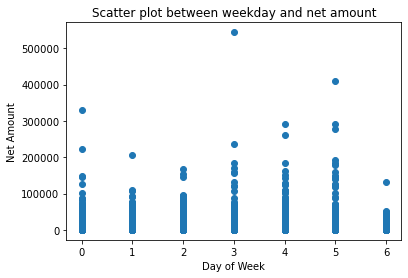

In [27]:
#Checking the relation with weekday and net amount
plt.scatter(x='Weekdaynum',y='Net Amount',data =bvwork)
plt.title("Scatter plot between weekday and net amount")
plt.xlabel("Day of Week")
plt.ylabel("Net Amount")
plt.show()

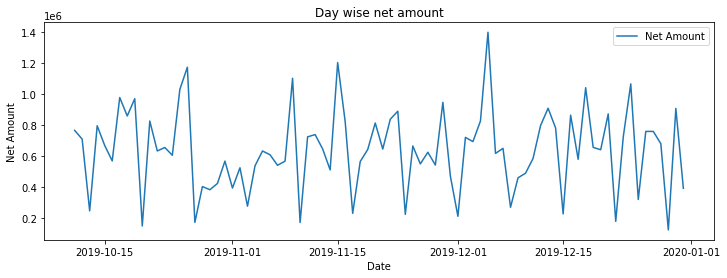

In [28]:
#plot the daywise net amount
bvwork[['Date','Net Amount']].groupby(by='Date').sum().plot(figsize=(12,4))
plt.title("Day wise net amount")
plt.xlabel("Date")
plt.ylabel("Net Amount")
plt.show()

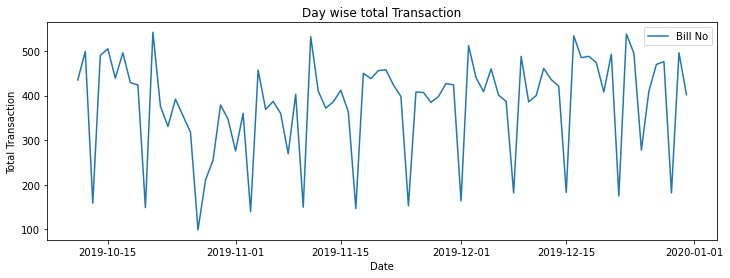

In [29]:
bvwork[['Date','Bill No']].groupby(by='Date').count().plot(figsize=(12,4))
plt.title("Day wise total Transaction")
plt.xlabel("Date")
plt.ylabel("Total Transaction")
plt.show()

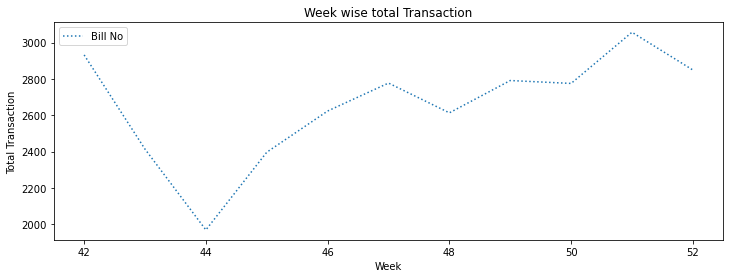

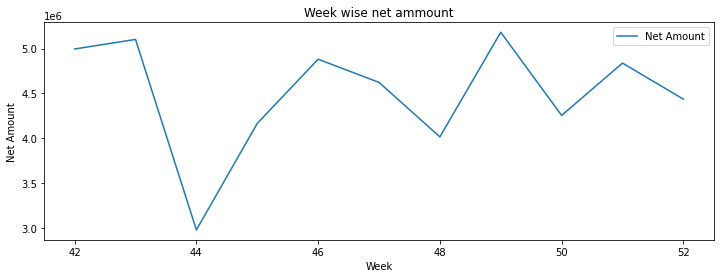

In [30]:
#Check the week transcation

bvwork[['Weekoftheyear','Bill No']][(bvwork['Weekoftheyear']>41)].groupby(by='Weekoftheyear').count().plot(figsize=(12,4),ls=':')
plt.title("Week wise total Transaction")
plt.xlabel("Week")
plt.ylabel("Total Transaction")
bvwork[['Weekoftheyear','Net Amount']][(bvwork['Weekoftheyear']>41)].groupby(by='Weekoftheyear').sum().plot(figsize=(12,4))
plt.title("Week wise net ammount")
plt.xlabel("Week")
plt.ylabel("Net Amount")
plt.show()

In [31]:
#Checking week day wise , Last pay mode wise Net Amount
bvwork[['Weekdaynum','Last Pay Mode','Net Amount']].pivot_table(index='Weekdaynum',columns=bvwork['Last Pay Mode'],aggfunc=np.sum)

Net Amount                                                  
Last Pay Mode       CARD     CASH  CHEQUE   FREE  PREPAID    RTGS      TPA
Weekdaynum                                                                
0                1484790  2284503  405248    800  1295010  123225  2173809
1                1606528  2227852   61879   1700  1281318   33571  1886999
2                1474413  1802408  231340  56315  1378759   26169  1748139
3                1394621  1959841   42520    700  2482320   17899  1692584
4                1786294  2688022   62771   1200  1425638   74676  3053069
5                1780970  1868011  132958  35610  2326793  221228  2859049
6                 586236   516339   87106    100   639624   11988   491306

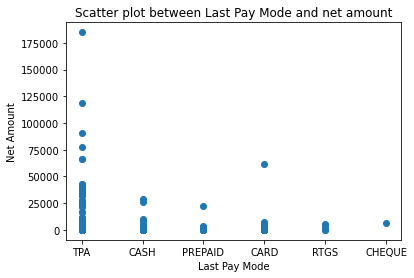

In [32]:
#Scatter plot between the Last PAy Mode and
plt.scatter(x='Last Pay Mode',y='Net Amount',data =bvwork.dropna())
plt.title("Scatter plot between Last Pay Mode and net amount")
plt.xlabel("Last Pay Mode")
plt.ylabel("Net Amount")
plt.show()

In [33]:
#Check the frequency distrbution on bill type
bvwork['Bill Type'].value_counts()

Pharmacy     14030
Reg/Cons      5871
Procedure     4586
Lab           4561
Rad           1492
Ip Bill        645
Name: Bill Type, dtype: int64

In [34]:
#Check the bill type wise net amount
bvwork[['Bill Type','Net Amount']].groupby('Bill Type').sum()

,Net Amount
Bill Type,
Ip Bill,24593115
Lab,6013329
Pharmacy,11756643
Procedure,6069481
Rad,1336740
Reg/Cons,2725883


In [35]:
#Bill Type + Last Pay mode and Net amount
bvwork[['Bill Type','Last Pay Mode','Net Amount']].groupby(by=['Bill Type','Last Pay Mode'],dropna = True).sum().sort_values(by=['Net Amount','Bill Type'],ascending=False)

Net Amount
Bill Type Last Pay Mode            
Ip Bill   TPA               8803451
          PREPAID           7502068
          CARD              4003525
Pharmacy  TPA               3514944
Procedure CASH              3141314
Ip Bill   CASH              3125416
Pharmacy  CASH              3072652
          CARD              2257765
Reg/Cons  CASH              1889540
Pharmacy  PREPAID           1716534
Procedure CARD              1619014
Lab       CASH              1549124
          PREPAID           1381210
          TPA               1236300
          CARD              1111436
Reg/Cons  CARD               766723
Ip Bill   CHEQUE             594736
Rad       CASH               568930
          CARD               355389
          TPA                277120
Pharmacy  CHEQUE             277086
Ip Bill   RTGS               267914
Pharmacy  RTGS               186292
Procedure PREPAID            147000
Lab       CHEQUE             109790
Ip Bill   FREE                90225
Rad       PREPAID             82650
Reg/Cons  TPA                 59120
Procedure CHEQUE              21460
Rad       CHEQUE              20750
          RTGS                19300
Lab       RTGS                17870
Procedure RTGS                15270
          TPA                 14020
Reg/Cons  FREE                 6200
          RTGS                 2110

## Section 2  - Null value imputation

3. Handle Null values and transform the data as needed. Ensure numeric, date columns are intact between the transformation stages.


In [36]:
bvwork.isnull().sum()/len(bvwork)

#SlNo             0.000000
Bill Type         0.000000
IPOP              0.000000
Bill No           0.000000
Bill Date         0.000000
Bill Amount       0.000000
Discount          0.000192
Net Amount        0.000000
Paid Amount       0.000000
Balance Amount    0.000000
Last Pay Mode     0.067725
User              0.000096
MRN               0.000000
AdmID             0.000000
Category          0.912811
Date              0.000000
Weekdaynum        0.000000
Weekday           0.000000
Weekoftheyear     0.000000
dtype: float64

In [37]:
#only three columns has null values - User, discount, Catergory and Last Pay mode

In [38]:
#user columns
bvwork[(bvwork['User'].isnull())]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear
21936,3286,Pharmacy,IP,47746,2019-12-28 10:11:54,6602,0.0,6602,6602,0,TPA,NaN,243571,2682,NaN,2019-12-28,5,Saturday,52
23317,4667,Pharmacy,IP,46974,2019-12-24 13:31:10,9521,0.0,9521,9521,0,TPA,NaN,437478,2653,NaN,2019-12-24,1,Tuesday,52
26139,7489,Pharmacy,IP,46959,2019-12-24 13:07:04,3773,0.0,3773,3773,0,TPA,NaN,474744,2661,NaN,2019-12-24,1,Tuesday,52


In [39]:
#USer column has just three rows as null, but still instead of dropping we can impute it with 'Unknown'
bvwork['User'][(bvwork['User'].isnull())] = bvwork['User'].replace(to_replace=np.NAN, value='Unknown')
bvwork[(bvwork['User'].isnull())]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear


In [40]:
bvwork[(bvwork['Discount'].isnull())]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear
7639,10,Ip Bill,IP,2259,2019-11-02 16:41:25,21870,NaN,21870,5435,16435,FREE,thriveni-csh,473636,2218,NaN,2019-11-02,5,Saturday,44
7667,38,Ip Bill,IP,2288,2019-11-07 11:32:38,159505,NaN,159505,159505,0,PREPAID,thriveni-csh,454914,2220,NaN,2019-11-07,3,Thursday,45
7688,59,Ip Bill,IP,2310,2019-11-09 14:38:09,25685,NaN,25685,25685,0,CASH,thriveni-csh,469960,2282,NaN,2019-11-09,5,Saturday,45
18655,5,Ip Bill,IP,2508,2019-12-01 14:26:24,14120,NaN,14120,14120,0,TPA,brundha s-csh,473777,2486,NaN,2019-12-01,6,Sunday,48
18656,6,Ip Bill,IP,2509,2019-12-01 14:27:15,6150,NaN,6150,6150,0,TPA,brundha s-csh,474237,2487,NaN,2019-12-01,6,Sunday,48
18657,7,Ip Bill,IP,2510,2019-12-01 17:22:45,2995,NaN,2995,2995,0,PREPAID,brundha s-csh,444462,2504,NaN,2019-12-01,6,Sunday,48


In [41]:
bvwork['Discount'][(bvwork['Discount'].isnull())] = bvwork['Bill Amount']-bvwork['Net Amount']
bvwork[(bvwork['Discount'].isnull())]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear


In [42]:
bvwork[(bvwork['Last Pay Mode'].isnull())]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear
65,66,Ip Bill,IP,2133,2019-10-18 14:45:10,53145,0.0,53145,0,53145,NaN,brundha s-csh,468643,2122,DIALYSIS,2019-10-18,4,Friday,42
134,135,Ip Bill,IP,2206,2019-10-25 18:21:34,4655,0.0,4655,0,4655,NaN,mahesh babu-csh,473604,2204,NaN,2019-10-25,4,Friday,43
179,180,Lab,OP,17820,2019-10-11 07:54:27,1180,0.0,1180,0,1180,NaN,geetha b-lab,9366,0,NaN,2019-10-11,4,Friday,41
180,181,Lab,OP,17821,2019-10-11 07:55:04,1180,0.0,1180,0,1180,NaN,geetha b-lab,9367,0,NaN,2019-10-11,4,Friday,41
195,196,Lab,OP,17842,2019-10-11 09:15:13,850,0.0,850,0,850,NaN,geetha b-lab,187023,0,STAFF,2019-10-11,4,Friday,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28999,10349,Rad,OP,23694,2019-12-28 09:00:04,0,0.0,0,0,0,NaN,bharathi h-opd,474836,0,NaN,2019-12-28,5,Saturday,52
29000,10350,Rad,OP,23691,2019-12-28 08:49:21,0,0.0,0,0,0,NaN,bharathi h-opd,449062,0,NaN,2019-12-28,5,Saturday,52
29001,10351,Rad,OP,23688,2019-12-28 08:46:15,0,0.0,0,0,0,NaN,bharathi h-opd,474834,0,NaN,2019-12-28,5,Saturday,52
29002,10352,Rad,OP,23686,2019-12-28 08:25:42,0,0.0,0,0,0,NaN,bharathi h-opd,454654,0,NaN,2019-12-28,5,Saturday,52


In [43]:
bvwork[(bvwork['Last Pay Mode'].isnull())].shape

(2112, 19)

In [44]:
#observed that Last Pay Mode is null for Bill Amount ==0
bvwork[(bvwork['Last Pay Mode'].isnull()) & (bvwork['Bill Amount']==0)].shape

(209, 19)

In [45]:
#observed that Last Pay Mode is null for net Amount ==0
bvwork[(bvwork['Last Pay Mode'].isnull()) & ((bvwork['Net Amount']==0) & (bvwork['Bill Amount']!=0))]

#observed that for 6 bill the entire amoutn was discounted and hence no payment was done and thats why Last Payment mode is null. We can impute them as Free

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear
931,932,Lab,OP,18773,2019-10-21 12:35:09,910,910.0,0,0,0,NaN,geetha b-lab,472269,0,NaN,2019-10-21,0,Monday,43
8410,781,Lab,OP,21312,2019-11-25 14:21:38,580,580.0,0,0,0,NaN,geetha b-lab,337653,0,NaN,2019-11-25,0,Monday,48
8456,827,Lab,OP,21389,2019-11-26 15:21:43,1520,1520.0,0,0,0,NaN,geetha b-lab,243241,0,NaN,2019-11-26,1,Tuesday,48
19416,766,Lab,OP,22429,2019-12-10 13:17:38,510,510.0,0,0,0,NaN,geetha b-lab,337653,0,NaN,2019-12-10,1,Tuesday,50
19789,1139,Lab,OP,22928,2019-12-17 18:06:14,1200,1200.0,0,0,0,NaN,geetha b-lab,11454,0,NaN,2019-12-17,1,Tuesday,51
20086,1436,Lab,OP,23256,2019-12-21 13:33:55,2030,2030.0,0,0,0,NaN,geetha b-lab,11566,0,NaN,2019-12-21,5,Saturday,51


In [46]:
bvwork['Last Pay Mode'][(bvwork['Last Pay Mode'].isnull()) & ((bvwork['Net Amount']==0) & (bvwork['Bill Amount']!=0))] = 'FREE'
bvwork[(bvwork['Last Pay Mode'].isnull()) & ((bvwork['Net Amount']==0) & (bvwork['Bill Amount']!=0))]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear


In [47]:
bvwork[(bvwork['Last Pay Mode'].isnull()) & ((bvwork['Net Amount']==0) & (bvwork['Bill Amount']==0))].shape

#observed that some 209 bill have 0 bill amount and hence no payment was done and we can mark as dummy bills

(209, 19)

In [48]:
bvwork['Last Pay Mode'][(bvwork['Last Pay Mode'].isnull()) & ((bvwork['Net Amount']==0) & (bvwork['Bill Amount']==0))] = 'Dummy'
bvwork[(bvwork['Last Pay Mode'].isnull()) & ((bvwork['Net Amount']==0) & (bvwork['Bill Amount']==0))]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear


In [49]:
bvwork[(bvwork['Last Pay Mode'].isnull()) & (bvwork['Balance Amount']!=0)]

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear
65,66,Ip Bill,IP,2133,2019-10-18 14:45:10,53145,0.0,53145,0,53145,NaN,brundha s-csh,468643,2122,DIALYSIS,2019-10-18,4,Friday,42
134,135,Ip Bill,IP,2206,2019-10-25 18:21:34,4655,0.0,4655,0,4655,NaN,mahesh babu-csh,473604,2204,NaN,2019-10-25,4,Friday,43
179,180,Lab,OP,17820,2019-10-11 07:54:27,1180,0.0,1180,0,1180,NaN,geetha b-lab,9366,0,NaN,2019-10-11,4,Friday,41
180,181,Lab,OP,17821,2019-10-11 07:55:04,1180,0.0,1180,0,1180,NaN,geetha b-lab,9367,0,NaN,2019-10-11,4,Friday,41
195,196,Lab,OP,17842,2019-10-11 09:15:13,850,0.0,850,0,850,NaN,geetha b-lab,187023,0,STAFF,2019-10-11,4,Friday,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28642,9992,Rad,IP,22250,2019-12-07 19:33:03,700,0.0,700,0,700,NaN,veena s-rad,474397,2545,NaN,2019-12-07,5,Saturday,49
28670,10020,Rad,IP,22149,2019-12-06 13:31:19,400,0.0,400,0,400,NaN,veena s-rad,474397,2545,NaN,2019-12-06,4,Friday,49
28763,10113,Rad,IP,21757,2019-12-02 08:47:50,650,0.0,650,0,650,NaN,shobha c-opd,472186,2481,NaN,2019-12-02,0,Monday,49
28946,10296,Rad,OP,23843,2019-12-30 13:11:41,700,0.0,700,0,700,NaN,anitha p-rad,183539,0,STAFF DEPENDENT,2019-12-30,0,Monday,1


In [50]:
#observed that 1897 rows have last pay mode as null but the bill ammount and balance amount is not zero.
#This means payment is overdue

bvwork['Last Pay Mode'][(bvwork['Last Pay Mode'].isnull()) & (bvwork['Balance Amount']!=0)] = 'DUE'
bvwork[(bvwork['Last Pay Mode'].isnull()) & (bvwork['Balance Amount']!=0)]


,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category,Date,Weekdaynum,Weekday,Weekoftheyear


In [51]:
bvwork[(bvwork['Last Pay Mode'].isnull())].shape

(0, 19)

In [52]:
#Category col has 91% null values, we can drop that colum
bvwork = bvwork.drop(columns='Category')

In [53]:
bvwork.isnull().sum()

#SlNo             0
Bill Type         0
IPOP              0
Bill No           0
Bill Date         0
Bill Amount       0
Discount          0
Net Amount        0
Paid Amount       0
Balance Amount    0
Last Pay Mode     0
User              0
MRN               0
AdmID             0
Date              0
Weekdaynum        0
Weekday           0
Weekoftheyear     0
dtype: int64

## Section 3 -  Anonymizer

4. Use python script for anonymizing ‘User’ column. (should be able to decode the anonymized column when needed)
5. Keep the anonymization as scalable, so that, in case there’s additional data to be added, the anonymizer should reuse the key values and anonymize only the new codes and add it to the key repository for decoding!

In [54]:
bvoct.head()

,#SlNo,Bill Type,IPOP,Bill No,Bill Date,Bill Amount,Discount,Net Amount,Paid Amount,Balance Amount,Last Pay Mode,User,MRN,AdmID,Category
0,1,Ip Bill,IP,2065,2019-10-11 12:42:18,170255,20000,150255,150255,0,CASH,thriveni-csh,473241,2056,NaN
1,2,Ip Bill,IP,2066,2019-10-11 13:12:55,23805,0,23805,23805,0,TPA,thriveni-csh,472750,2069,NaN
2,3,Ip Bill,IP,2067,2019-10-11 13:18:50,24835,0,24835,24835,0,TPA,thriveni-csh,194381,2050,NaN
3,4,Ip Bill,IP,2068,2019-10-11 13:33:59,25145,1439,23706,23706,0,TPA,thriveni-csh,425772,2045,NaN
4,5,Ip Bill,IP,2069,2019-10-11 15:02:19,102350,0,102350,102350,0,PREPAID,thriveni-csh,473242,2057,NaN


In [55]:
from cryptography.fernet import Fernet
key = Fernet.generate_key()
fernet = Fernet(key)

In [56]:
bvwork['encU'] = 0
for i in range(0 , len(bvwork)):
    bvwork['encU'][i] = fernet.encrypt(bvwork['User'][i].encode())

In [57]:
# Decoding back to original name
bvwork['decoU'] = 0
for i in range(0 , len(bvwork)):
    bvwork['decoU'][i] = fernet.decrypt(bvwork['encU'][i]).decode()

In [58]:
#checking if decoding worked
(bvwork['User'] !=bvwork['decoU']).sum()

0

In [59]:
#checking scalability
username = 'Roona Shree'
encoded_name = fernet.encrypt(username.encode())

decoded_name = fernet.decrypt(encoded_name).decode()

print("Encoded name ",encoded_name)
print("Decode name",decoded_name)
print("Username",username)

Encoded name  b'gAAAAABheDq2ivEm04ZRm1hUnwrNOenGCg9NqsLkpfdFy-cy5Hck66k2Py6VFG4TfHZXA6hnRBoIS5kMfIV0zf4yi0xF53_gUg=='
Decode name Roona Shree
Username Roona Shree


In [60]:
bvwork = bvwork.drop(columns=['User','decoU'])

In [61]:
bvwork.columns

Index(['#SlNo', 'Bill Type', 'IPOP', 'Bill No', 'Bill Date', 'Bill Amount',
       'Discount', 'Net Amount', 'Paid Amount', 'Balance Amount',
       'Last Pay Mode', 'MRN', 'AdmID', 'Date', 'Weekdaynum', 'Weekday',
       'Weekoftheyear', 'encU'],
      dtype='object')

In [62]:
bvwork.to_excel('Hospitialrevenue.xls')

## Section 4 - Data Prep for Forecasting

In [63]:
#Take the subset of data which is required for forecast modelling
df_daywise = bvwork[['Date','Net Amount','Last Pay Mode']]

In [64]:
df_daywise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31185 entries, 0 to 31184
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           31185 non-null  object
 1   Net Amount     31185 non-null  int64 
 2   Last Pay Mode  31185 non-null  object
dtypes: int64(1), object(2)
memory usage: 731.0+ KB


In [65]:
df_daywise.head()

,Date,Net Amount,Last Pay Mode
0,2019-10-11,150255,CASH
1,2019-10-11,23805,TPA
2,2019-10-11,24835,TPA
3,2019-10-11,23706,TPA
4,2019-10-11,102350,PREPAID


In [66]:
df_d = df_daywise[['Date','Net Amount']].groupby(by='Date').agg({'Date':pd.Series.count,"Net Amount":np.sum})
df_d['Avg Amount per Transaction'] = df_d['Net Amount']/df_d['Date']
df_d

,Date,Net Amount,Avg Amount per Transaction
Date,,,
2019-10-11,435,766941,1763.082759
2019-10-12,499,710332,1423.511022
2019-10-13,159,246949,1553.138365
2019-10-14,490,796754,1626.028571
2019-10-15,505,669380,1325.504950
...,...,...,...
2019-12-27,470,760155,1617.351064
2019-12-28,476,680858,1430.373950
2019-12-29,182,124082,681.769231


<AxesSubplot:>

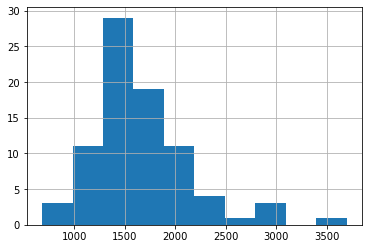

In [67]:
df_d['Avg Amount per Transaction'].hist()

<AxesSubplot:xlabel='Date'>

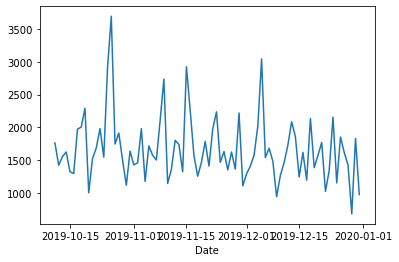

In [68]:
df_d['Avg Amount per Transaction'].plot()

In [69]:
#saved the average amount per transaction in variable
# this will later be used to multiply forecasted no of transactions
avg_amount_per_transcation = df_d['Avg Amount per Transaction'].mean()

In [70]:
df_d.columns=['Daily Transaction Count','Net Amount','Avg Amount per Transaction']

In [71]:
df_d.head()

,Daily Transaction Count,Net Amount,Avg Amount per Transaction
Date,,,
2019-10-11,435,766941,1763.082759
2019-10-12,499,710332,1423.511022
2019-10-13,159,246949,1553.138365
2019-10-14,490,796754,1626.028571
2019-10-15,505,669380,1325.504950


In [72]:
#create a table for each payment mode 
df_paymode = bvwork[['Date','Net Amount','Last Pay Mode']]

In [73]:
df_p = pd.pivot_table(df_paymode,index='Date',columns=df_paymode['Last Pay Mode'],aggfunc=np.sum,fill_value=0)

df_p.head()

Net Amount                                                 \
Last Pay Mode       CARD    CASH CHEQUE    DUE Dummy FREE PREPAID  RTGS   
Date                                                                      
2019-10-11        152893  304997      0  31140     0    0  161231     0   
2019-10-12        146759  233165      0  37942     0    0   76959     0   
2019-10-13         77587   35795      0   4206     0    0   84305     0   
2019-10-14         85118  227567   3209  60054     0    0  232756     0   
2019-10-15        106271  224092   1811  37449     0    0  122023  1400   

                       
Last Pay Mode     TPA  
Date                   
2019-10-11     116680  
2019-10-12     215507  
2019-10-13      45056  
2019-10-14     188050  
2019-10-15     176334

In [74]:
df_p.columns = ['CARD','CASH','CHEQUE','DUE','Dummy','FREE','PREPAID','RTGS','TPA']

In [75]:
df_p.describe()

,CARD,CASH,CHEQUE,DUE,Dummy,FREE,PREPAID,RTGS,TPA
count,82.000000,82.000000,82.000000,82.000000,82.0,82.000000,82.000000,82.000000,82.000000
mean,123339.658537,162768.000000,12485.634146,32572.475610,0.0,1175.914634,132066.609756,6204.341463,169572.621951
std,66403.916325,73218.075612,41320.183464,19451.258681,0.0,6696.359944,124830.281951,19343.209748,133468.565242
min,17038.000000,17108.000000,0.000000,4206.000000,0.0,0.000000,10045.000000,0.000000,9534.000000
25%,76704.250000,109401.000000,0.000000,22010.250000,0.0,0.000000,55358.000000,0.000000,82413.750000
50%,116634.500000,164640.000000,543.000000,29252.500000,0.0,0.000000,87440.500000,699.500000,118985.000000
75%,156408.000000,210257.250000,7823.250000,36495.000000,0.0,100.000000,194112.750000,3632.500000,235851.750000
max,390607.000000,317208.000000,331366.000000,145841.000000,0.0,55715.000000,811658.000000,146791.000000,679984.000000


In [76]:
#dropping the dummy mode as it is not contributing to net amount
df_p = df_p.drop(columns='Dummy')

In [77]:
df_p.head()

,CARD,CASH,CHEQUE,DUE,FREE,PREPAID,RTGS,TPA
Date,,,,,,,,
2019-10-11,152893,304997,0,31140,0,161231,0,116680
2019-10-12,146759,233165,0,37942,0,76959,0,215507
2019-10-13,77587,35795,0,4206,0,84305,0,45056
2019-10-14,85118,227567,3209,60054,0,232756,0,188050
2019-10-15,106271,224092,1811,37449,0,122023,1400,176334


In [78]:
df_p['Daily Net Amount'] = df_p['CARD']+ df_p['CASH']+ df_p['CHEQUE']+ df_p['DUE']+ df_p['FREE']+ df_p['PREPAID']+ df_p['RTGS']+ df_p['TPA']
df_p.head()

,CARD,CASH,CHEQUE,DUE,FREE,PREPAID,RTGS,TPA,Daily Net Amount
Date,,,,,,,,,
2019-10-11,152893,304997,0,31140,0,161231,0,116680,766941
2019-10-12,146759,233165,0,37942,0,76959,0,215507,710332
2019-10-13,77587,35795,0,4206,0,84305,0,45056,246949
2019-10-14,85118,227567,3209,60054,0,232756,0,188050,796754
2019-10-15,106271,224092,1811,37449,0,122023,1400,176334,669380


In [79]:
df_avgp = df_p.copy()

## Assumption : - Proportion of Payment mode is constant over 6 months to 1 year

In [80]:
# Here I have taken the propotion of each payment mode of each day 
# I am taking the average of daily porportions for each payment mode
# I am assuming that this average proportion is constant.


for i in df_avgp.columns:
    df_avgp[i] = df_avgp[i]/df_avgp['Daily Net Amount']
avg_paymode = df_avgp.mean()

In [81]:
df_d.to_excel("Hospitalrevenue_daywise.xls")

In [82]:
df_p.to_excel("Hospitalrevenue_paymode.xls")

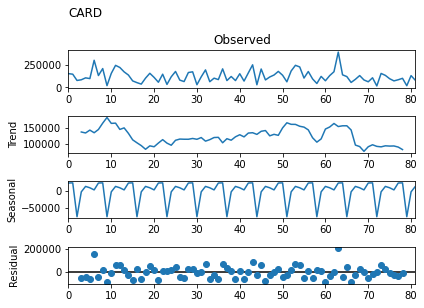

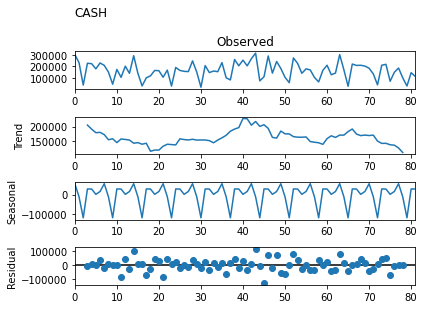

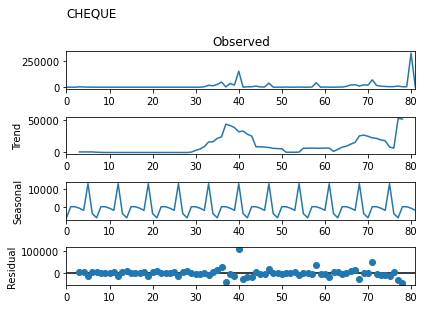

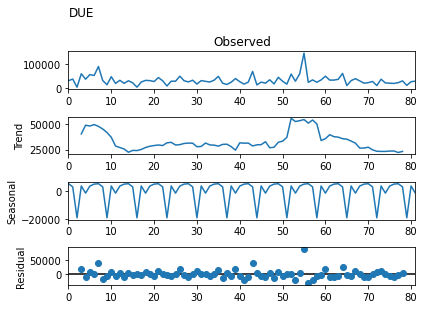

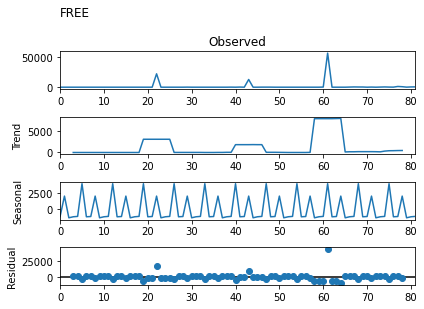

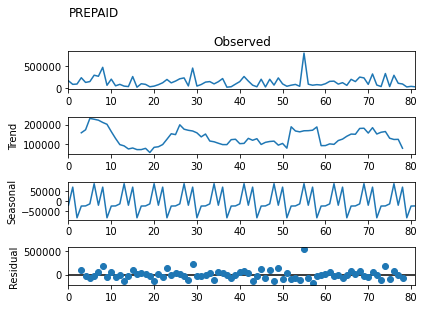

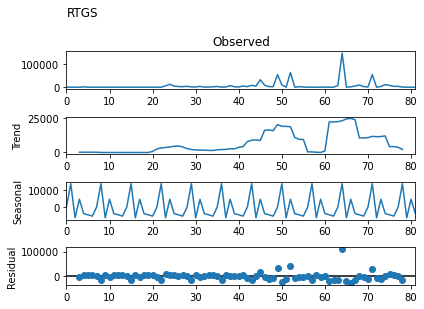

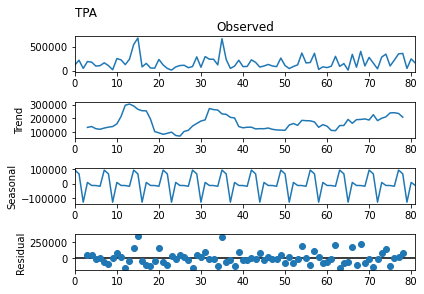

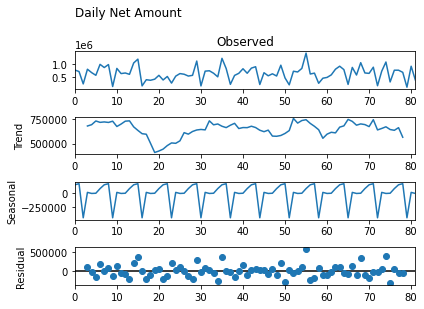

<Figure size 1008x504 with 0 Axes>

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in df_p.columns:
    ts_decompose = seasonal_decompose(np.array(df_p[i]),
                                 model='additive',
                                 period = 7)
    #plotting the decomposed time series components
    ts_plot = ts_decompose.plot()
    plt.title(i,loc='left',y=7.0)
plt.figure(figsize=(14,7))
plt.show()

# Approach 1- 
# Train Test Split for Daily Transaction count

In [84]:

dt_train = df_d[['Daily Transaction Count']][0:67]
dt_test  = df_d[['Daily Transaction Count']][67:]

In [85]:
from sklearn.metrics import mean_squared_error

In [86]:
# Function to calcule the Mean Absolute Percentage Error
def get_mape(actual,predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round(np.mean(np.abs((actual-predicted)/actual))*100,2)

In [87]:
#Initializing
dt_pred = dt_test.copy()
model_name = []
MAPE = []
RMSE = []

In [88]:
#Method 1 - Simple average
dt_pred['Simple Average'] = dt_train.mean()[0]

mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['Simple Average'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['Simple Average']))

print("MAPE ",mape)
print("RMSE ",rmse)


model_name.append("Simple Average")
MAPE.append(mape)
RMSE.append(rmse)



MAPE  32.87
RMSE  120.36656340693781


In [89]:
#Method 2 - Simple Moving Average
SMAvg = df_d['Daily Transaction Count'].rolling(window=7).mean().shift(1)

dt_pred['SMAvg'] = SMAvg[67:]

mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['SMAvg'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['SMAvg']))

print("MAPE ",mape)
print("RMSE ",rmse)

model_name.append("Simple Moving Average")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  31.27
RMSE  113.9242139784701


In [90]:
#Method 3 Exponential Smoothing
ewm = df_d['Daily Transaction Count'].ewm(alpha=0.2).mean()

dt_pred['ewm'] = ewm[67:]


mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['ewm'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['ewm']))

print("MAPE ",mape)
print("RMSE ",rmse)

model_name.append("Single Exponential Smoothing")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  26.76
RMSE  98.21169431776526


In [91]:
# Method 4 - Double Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(dt_train,trend='add',freq='D')
model = model.fit()

dt_pred['des'] = model.forecast(len(dt_test))

mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['des'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['des']))

print("MAPE ",mape)
print("RMSE ",rmse)

model_name.append("Double Exponential Smoothing")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  31.08
RMSE  112.99883499992839


In [92]:
#Method 5 - Triple Exponential Smoothing

model = ExponentialSmoothing(dt_train,trend='add',seasonal='add',seasonal_periods=7,freq='D')
model = model.fit(optimized=True)

dt_pred['tes'] = model.forecast(len(dt_test))

mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['tes'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['tes']))

print("MAPE ",mape)
print("RMSE ",rmse)

model_name.append("Triple Exponential Smoothing")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  11.31
RMSE  55.13803328590829


In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

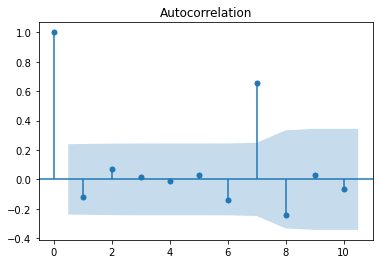

In [94]:
acf_plot = plot_acf(dt_train,lags = 10)

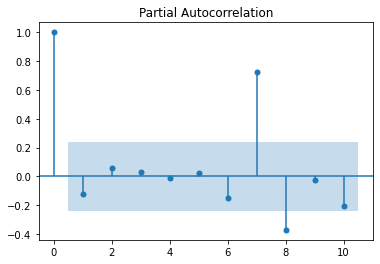

In [95]:
pacf_plot = plot_pacf(dt_train,lags=10)

In [96]:
#dickey fuller test
#perform 1 order diffrencing to make the series stationary
df_test = adfuller(dt_train.diff().dropna())
df_test

(-4.065157753082937,
 0.0011052421127957864,
 6,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 623.1192086090118)

In [97]:
from pmdarima import auto_arima
model = auto_arima(dt_train,
                    start_p=0,start_q=0,
                    max_p=10,max_q=10,d=1,
                    trace=True,seasonal=True,m=7,
                    information_criterion='aic'
                    ,stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=865.802, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=778.641, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=863.807, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=840.437, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=752.146, Time=0.68 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=809.720, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=803.190, Time=0.64 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(

In [98]:
#Method 6 - ARIMA Model
model = ARIMA(dt_train['Daily Transaction Count'],order=(1,1,0))
model = model.fit(opentimized = True)
#model.summary()
dt_pred['arima'] = model.forecast(len(dt_test))[0]


mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['arima'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['arima']))

print("MAPE ",mape)
print("RMSE ",rmse)

model_name.append("ARIMA")
MAPE.append(mape)
RMSE.append(rmse)

#results.summary()

MAPE  32.16
RMSE  119.4291262303572


C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [99]:
#Method 7- Seasonal ARIMA Model

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(dt_train,order=(1,1,0),seasonal_order=(1,0,1,7)).fit()

dt_pred['sarima'] = model.forecast(len(dt_test))


mape = get_mape(dt_test['Daily Transaction Count'],dt_pred['sarima'])
rmse = np.sqrt(mean_squared_error(dt_test['Daily Transaction Count'],dt_pred['sarima']))

print("MAPE ",mape)
print("RMSE ",rmse)

model_name.append("SARIMA")
MAPE.append(mape)
RMSE.append(rmse)

#results.summary()

C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


MAPE  12.98
RMSE  59.435673248744195


C:\Users\shree\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Performance Table of all the Models for Daily Transaction Count

In [100]:

dt_model_evaluation = pd.DataFrame({'Model_name':model_name,'MAPE':MAPE,'RMSE':RMSE})
dt_model_evaluation

,Model_name,MAPE,RMSE
0,Simple Average,32.87,120.366563
1,Simple Moving Average,31.27,113.924214
2,Single Exponential Smoothing,26.76,98.211694
3,Double Exponential Smoothing,31.08,112.998835
4,Triple Exponential Smoothing,11.31,55.138033
5,ARIMA,32.16,119.429126
6,SARIMA,12.98,59.435673


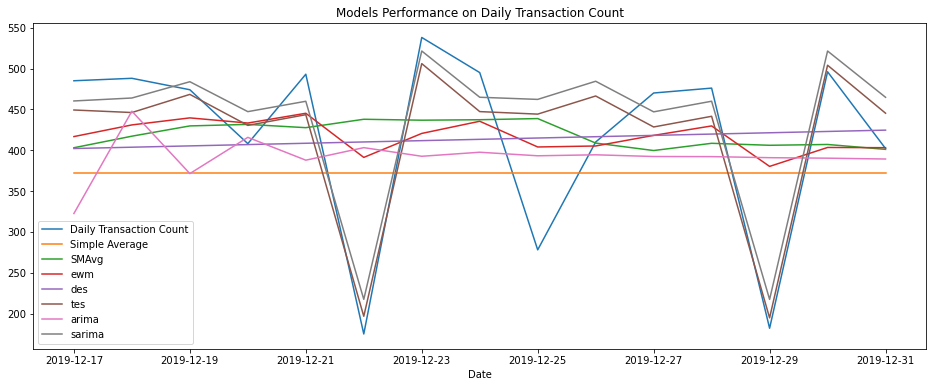

In [101]:
dt_pred.plot(figsize=(16,6))
plt.title("Models Performance on Daily Transaction Count")
plt.show()

In [102]:
#Forecasting of net Amount by using forecasted no of daily transaction
dt_pred['Forecasted_net_amount'] = dt_pred['tes']*avg_amount_per_transcation

In [103]:
#Day wise performance
final_mape = get_mape(df_d['Net Amount'][67:],dt_pred['Forecasted_net_amount'])
final_rmse = np.sqrt(mean_squared_error(df_d['Net Amount'][67:],dt_pred['Forecasted_net_amount']))

print("MAPE " ,final_mape)
print("RMSE ", final_rmse)

MAPE  42.56
RMSE  207333.20168084084


In [104]:
# Performance or Error - over the period of 15 day

np.abs(df_d['Net Amount'][67:].sum()-dt_pred['Forecasted_net_amount'].sum())/df_d['Net Amount'][67:].sum()*100

8.316512510780408

## Approach 2- 
# Train Test Split for Daily Transaction count

In [105]:
dn_train = df_d[['Net Amount']][0:67]
dn_test = df_d[['Net Amount']][67:]

In [106]:
dn_pred = dn_test.copy()
model_name = []
MAPE = []
RMSE = []

In [107]:
#Method 1 - Simple average
dn_pred['Simple Average'] = dn_train.mean()[0]

mape = get_mape(dn_test['Net Amount'],dn_pred['Simple Average'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['Simple Average']))

print("MAPE ",mape)
print("RMSE ",rmse) 


model_name.append("Simple Average")
MAPE.append(mape)
RMSE.append(rmse)



MAPE  68.76
RMSE  277343.5378318853


In [108]:
#Method 2 - Simple Moving Average
SMAvg = df_d['Net Amount'].rolling(window=7).mean().shift(1)

dn_pred['SMAvg'] = SMAvg[67:]

mape = get_mape(dn_test['Net Amount'],dn_pred['SMAvg'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['SMAvg']))

print("MAPE ",mape)
print("RMSE ",rmse) 

model_name.append("Simple Moving Average")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  73.77
RMSE  286853.940932903


In [109]:
#Method 3 Exponential Smoothing
ewm = df_d['Net Amount'].ewm(alpha=0.2).mean()

dn_pred['ewm'] = ewm[67:]

mape = get_mape(dn_test['Net Amount'],dn_pred['ewm'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['ewm']))

print("MAPE ",mape)
print("RMSE ",rmse) 

model_name.append("Single Exponential Smoothing")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  62.0
RMSE  242423.08379042344


In [110]:
# Method 4 - Double Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(dn_train,trend='add',freq='D')
model = model.fit()

dn_pred['des'] = model.forecast(len(dn_test))

mape = get_mape(dn_test['Net Amount'],dn_pred['des'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['des']))

print("MAPE ",mape)
print("RMSE ",rmse) 

model_name.append("Double Exponential Smoothing")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  69.27
RMSE  276899.0426800113


C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [111]:
#Method 5 - Triple Exponential Smoothing

model = ExponentialSmoothing(dn_train,trend='add',seasonal='add',seasonal_periods=7,freq='D')
model = model.fit(optimized=True)

dn_pred['tes'] = model.forecast(len(dn_test))

mape = get_mape(dn_test['Net Amount'],dn_pred['tes'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['tes']))

print("MAPE ",mape)
print("RMSE ",rmse) 

model_name.append("Triple Exponential Smoothing")
MAPE.append(mape)
RMSE.append(rmse)

MAPE  27.72
RMSE  214546.9813745338


C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


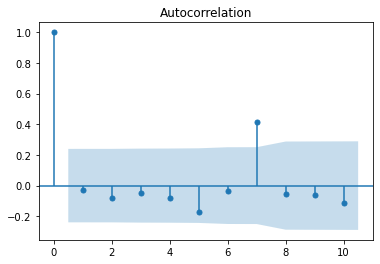

In [112]:
acf_plot = plot_acf(dn_train,lags = 10)

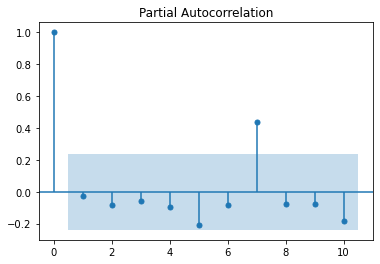

In [113]:
pacf_plot = plot_pacf(dn_train,lags=10)

In [114]:
#dickey fuller test
#perform 2 order diffrencing to make the series stationary
df_test = adfuller(dn_train.diff().diff().dropna())
df_test

(-2.7698187600612214,
 0.06271594674985621,
 11,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 1496.0523394330473)

In [115]:
from pmdarima import auto_arima
model = auto_arima(dn_train,
                    start_p=0,start_q=0,
                    max_p=10,max_q=10,d=2,
                    trace=True,seasonal=True,m=7,
                    information_criterion='aic'
                    ,stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1901.217, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1925.456, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1882.431, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=1896.035, Time=0.02 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=1873.717, Time=0.16 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=1875.703, Time=0.33 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=1874.512, Time=0.19 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=1897.698, Time=0.13 sec
 ARIMA(2,2,0)(2,0,0)[7]             : AIC=1855.760, Time=0.22 sec
 ARIMA(2,2,0)(1,0,0)[7]             : AIC=1862.845, Time=0.11 sec
 ARIMA(2,2,0)(2,0,1)[7]             : AIC=1857.009, Time=0.49 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=1855.733, Time=0.29 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=1869.887, Time=0.14 sec
 ARIMA(2,2,0)(1,0,2)[7]             : 

In [116]:
#Method 6 - ARIMA Model
model = ARIMA(dn_train['Net Amount'],order=(3,2,4))
model = model.fit(opentimized = True)
#model.summary()
dn_pred['arima'] = model.forecast(len(dn_test))[0]

mape = get_mape(dn_test['Net Amount'],dn_pred['arima'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['arima']))

print("MAPE ",mape)
print("RMSE ",rmse) 

model_name.append("ARIMA")
MAPE.append(mape)
RMSE.append(rmse)

#results.summary()

C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


MAPE  154.45
RMSE  583029.9163986358


In [117]:
#Method 7- Seasonal ARIMA Model
#from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(dn_train,order=(3,2,4),seasonal_order=(1,0,1,7)).fit()

dn_pred['sarima'] = model.forecast(len(dn_test))

mape = get_mape(dn_test['Net Amount'],dn_pred['sarima'])
rmse = np.sqrt(mean_squared_error(dn_test['Net Amount'],dn_pred['sarima']))

print("MAPE ",mape)
print("RMSE ",rmse) 

model_name.append("SARIMA")
MAPE.append(mape)
RMSE.append(rmse)

#results.summary()

C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


MAPE  75.47
RMSE  319752.6453343544


C:\Users\shree\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Perfromance Table of all the Models for Daily Net Amount

In [118]:
dn_model_evaluation = pd.DataFrame({'Model_name':model_name,'MAPE':MAPE,'RMSE':RMSE})
dn_model_evaluation

,Model_name,MAPE,RMSE
0,Simple Average,68.76,277343.537832
1,Simple Moving Average,73.77,286853.940933
2,Single Exponential Smoothing,62.00,242423.083790
3,Double Exponential Smoothing,69.27,276899.042680
4,Triple Exponential Smoothing,27.72,214546.981375
5,ARIMA,154.45,583029.916399
6,SARIMA,75.47,319752.645334


# Triple Exponential Smoothing gave the best performance

In [119]:
#creating dataframe for final forecasting
final_test_forecast = pd.DataFrame({'Net Amount':dn_pred['tes']})

In [120]:
df_avgp.mean()

CARD                0.202865
CASH                0.260397
CHEQUE              0.019192
DUE                 0.054148
FREE                0.001964
PREPAID             0.199237
RTGS                0.008793
TPA                 0.253403
Daily Net Amount    1.000000
dtype: float64

In [121]:
#Creating Last Pay Mode wise predictions
final_test_forecast['CARD'] = np.round(df_avgp.mean().CARD*final_test_forecast['Net Amount'],2)
final_test_forecast['CASH'] = np.round(df_avgp.mean().CASH*final_test_forecast['Net Amount'],2)
final_test_forecast['CHEQUE'] = np.round(df_avgp.mean().CHEQUE*final_test_forecast['Net Amount'],2)
final_test_forecast['DUE'] = np.round(df_avgp.mean().DUE*final_test_forecast['Net Amount'],2)
final_test_forecast['PREPAID'] = np.round(df_avgp.mean().PREPAID*final_test_forecast['Net Amount'],2)
final_test_forecast['FREE'] = np.round(df_avgp.mean().FREE*final_test_forecast['Net Amount'],2)
final_test_forecast['RTGS'] = np.round(df_avgp.mean().RTGS*final_test_forecast['Net Amount'],2)
final_test_forecast['TPA'] = np.round(df_avgp.mean().TPA*final_test_forecast['Net Amount'],2)


In [122]:
final_test_forecast.to_excel('Final__test_forecast.xls')

# Final forecast performance

In [123]:
(dn_test['Net Amount'].sum() - dn_pred['tes'].sum())/dn_test['Net Amount'].sum()*100

4.6424422121093

# Final Model Deployment

In [133]:
import pickle
import os

In [137]:
os.chdir(r"C:\Users\shree\Desktop\hosptial_optimization")

In [ ]:
with open("Pickle_file_iris.pkl",'wb') as file:
    pickle.dump(clf_gini,file)

In [132]:
model = ExponentialSmoothing(df_d[['Net Amount']],trend='add',seasonal='add',seasonal_periods=7,freq='D')
model = model.fit(optimized=True)

C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [138]:
with open("Pickle_file_ho.pkl",'wb') as file:
    pickle.dump(model,file)

In [139]:
with open("Pickle_file_ho.pkl",'rb') as file:
    pickledmodel = pickle.load(file)

In [141]:
forecast_netamount1 = pickledmodel.forecast(15)

In [143]:
forecast_netamount1

2020-01-01    598608.112124
2020-01-02    780430.606392
2020-01-03    750626.621481
2020-01-04    730131.540067
2020-01-05    181199.813672
2020-01-06    694241.764022
2020-01-07    631787.553255
2020-01-08    593606.197641
2020-01-09    775428.691909
2020-01-10    745624.706999
2020-01-11    725129.625585
2020-01-12    176197.899189
2020-01-13    689239.849539
2020-01-14    626785.638772
2020-01-15    588604.283159
Freq: D, dtype: float64

In [125]:
# Triple Exponential Smoothing

model = ExponentialSmoothing(df_d[['Net Amount']],trend='add',seasonal='add',seasonal_periods=7,freq='D')
model = model.fit(optimized=True)
#model.summary(15)

forecast_netamount = model.forecast(15)

C:\Users\shree\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [126]:
forecast = pd.DataFrame({'Daily Net Amount':forecast_netamount})

In [127]:
#
#Creating Last Pay Mode wise predictions
forecast['CARD'] = np.round(df_avgp.mean().CARD*forecast['Daily Net Amount'],2)
forecast['CASH'] = np.round(df_avgp.mean().CASH*forecast['Daily Net Amount'],2)
forecast['CHEQUE'] = np.round(df_avgp.mean().CHEQUE*forecast['Daily Net Amount'],2)
forecast['DUE'] = np.round(df_avgp.mean().DUE*forecast['Daily Net Amount'],2)
forecast['PREPAID'] = np.round(df_avgp.mean().PREPAID*forecast['Daily Net Amount'],2)
forecast['FREE'] = np.round(df_avgp.mean().FREE*forecast['Daily Net Amount'],2)
forecast['RTGS'] = np.round(df_avgp.mean().RTGS*forecast['Daily Net Amount'],2)
forecast['TPA'] = np.round(df_avgp.mean().TPA*forecast['Daily Net Amount'],2)


In [128]:
forecast.to_excel("Hospitalnetamountforecast.xls")

In [129]:
df_p.append(forecast[['CARD', 'CASH', 'CHEQUE', 'DUE', 'FREE', 'PREPAID', 'RTGS', 'TPA',
       'Daily Net Amount']])

,CARD,CASH,CHEQUE,DUE,FREE,PREPAID,RTGS,TPA,Daily Net Amount
2019-10-11,152893.00,304997.00,0.00,31140.00,0.00,161231.00,0.00,116680.00,766941.000000
2019-10-12,146759.00,233165.00,0.00,37942.00,0.00,76959.00,0.00,215507.00,710332.000000
2019-10-13,77587.00,35795.00,0.00,4206.00,0.00,84305.00,0.00,45056.00,246949.000000
2019-10-14,85118.00,227567.00,3209.00,60054.00,0.00,232756.00,0.00,188050.00,796754.000000
2019-10-15,106271.00,224092.00,1811.00,37449.00,0.00,122023.00,1400.00,176334.00,669380.000000
...,...,...,...,...,...,...,...,...,...
2020-01-11 00:00:00,147103.67,188821.64,13916.76,39264.26,1423.88,144472.67,6376.42,183750.33,725129.625585
2020-01-12 00:00:00,35744.45,45881.42,3381.61,9540.75,345.99,35105.15,1549.39,44649.15,176197.899189
2020-01-13 00:00:00,139822.88,179476.04,13227.96,37320.91,1353.41,137322.10,6060.82,174655.74,689239.849539
2020-01-14 00:00:00,127153.08,163213.15,12029.33,33939.14,1230.77,124878.91,5511.63,158829.63,626785.638772


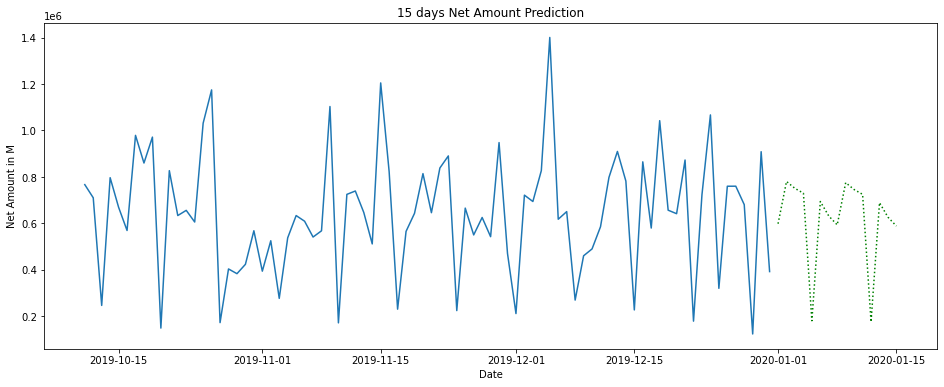

In [130]:
plt.figure(figsize=(16,6))
plt.plot(df_p['Daily Net Amount'])
plt.plot(forecast['Daily Net Amount'],color='g',ls=':')
plt.title("15 days Net Amount Prediction")
plt.xlabel("Date")
plt.ylabel("Net Amount in M")
plt.show()

In [131]:
df_p.to_excel("Hosptialnetamount.xls")